Superviso 에이전트 시스템(주식 종목 평가하기)

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)
python_repl_tool = PythonREPLTool()

In [3]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

def get_history_prices(ticker:yf.Ticker, last_days:int = 5):
    historical_prices = ticker.history(period=str(last_days)+'d', interval='1d')

    last_days_close = historical_prices['Close'].tail(5)
    last_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_days_close.items()}
    return last_days_close_dict


In [51]:
# Test
ticker = yf.Ticker("BA")

def format_number(number):
    if number is None or pd.isna(number):
        return "N/A"
    return f"{number:,.0f}"

def format_financial_summary(financials):
    summary = {}
    for date, data in financials.items():
        date_str = date.strftime('%Y-%m-%d')
        summary[date_str] = {
            "총수익": format_number(data.get('TotalRevenue')),
            "영업수익": format_number(data.get('OperatingIncome')),
            "순수익": format_number(data.get('NetIncome')),
            "EBITDA": format_number(data.get('EBITA')),
            "EPS": f"${data.get('DilutedEPS'):.2f}" if pd.notna(data.get('DilutedEPS')) else "N/A",
        }
    return summary
last_5_days_close_dict = get_history_prices(ticker, 5)
annual_financials = ticker.get_financials()
quarterly_financials = ticker.get_financials(freq='quarterly')

result = str({
    "최근 5일간 종가": last_5_days_close_dict,
    "연간 재무제표 요약" : format_financial_summary(annual_financials),
    "분기별 재무제표 요약" : format_financial_summary(quarterly_financials),
})

result

"{'최근 5일간 종가': {'2025-01-28': 177.77999877929688, '2025-01-29': 173.66000366210938, '2025-01-30': 179.52999877929688, '2025-01-31': 176.52000427246094, '2025-02-03': 175.8699951171875}, '연간 재무제표 요약': {'2023-12-31': {'총수익': '77,794,000,000', '영업수익': '-821,000,000', '순수익': '-2,222,000,000', 'EBITDA': 'N/A', 'EPS': '$-3.67'}, '2022-12-31': {'총수익': '66,608,000,000', '영업수익': '-3,509,000,000', '순수익': '-4,935,000,000', 'EBITDA': 'N/A', 'EPS': '$-8.30'}, '2021-12-31': {'총수익': '62,286,000,000', '영업수익': '-3,357,000,000', '순수익': '-4,202,000,000', 'EBITDA': 'N/A', 'EPS': '$-7.15'}, '2020-12-31': {'총수익': '58,158,000,000', '영업수익': '-12,978,000,000', '순수익': '-11,941,000,000', 'EBITDA': 'N/A', 'EPS': '$-20.88'}}, '분기별 재무제표 요약': {'2024-09-30': {'총수익': '17,840,000,000', '영업수익': '-5,746,000,000', '순수익': '-6,170,000,000', 'EBITDA': 'N/A', 'EPS': '$-9.97'}, '2024-06-30': {'총수익': '16,866,000,000', '영업수익': '-1,102,000,000', '순수익': '-1,439,000,000', 'EBITDA': 'N/A', 'EPS': '$-2.33'}, '2024-03-31': {'총수익': '16

In [52]:
from langchain.tools import BaseTool, StructuredTool, tool

@tool
def stock_analysis(ticker_code: str) -> str:
    """
    Permforms updated comprehensive financial analysis for a given stock ticker.  
    Provides lastest stock price, financial indicators, growth rates, valuatons and major rations provides.
    Use most recent business days data.

    :param ticker_code : target stock ticker
    :return : string includes finance analysis results of the given stock
    """
    def format_number(number):
        if number is None or pd.isna(number):
            return "N/A"
        return f"{number:,.0f}"

    def format_financial_summary(financials):
        summary = {}
        for date, data in financials.items():
            date_str = date.strftime('%Y-%m-%d')
            summary[date_str] = {
                "총수익": format_number(data.get('TotalRevenue')),
                "영업수익": format_number(data.get('OperatingIncome')),
                "순수익": format_number(data.get('NetIncome')),
                "EBITDA": format_number(data.get('EBITA')),
                "EPS": f"${data.get('DilutedEPS'):.2f}" if pd.notna(data.get('DilutedEPS')) else "N/A",
            }
        return summary
    ticker = yf.Ticker(ticker_code)
    last_5_days_close_dict = get_history_prices(ticker, 5)
    annual_financials = ticker.get_financials()
    quarterly_financials = ticker.get_financials(freq='quarterly')
    
    return str({
        "최근 5일간 종가": last_5_days_close_dict,
        "연간 재무제표 요약" : format_financial_summary(annual_financials),
        "분기별 재무제표 요약" : format_financial_summary(quarterly_financials),
    })

In [29]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Stock_Analyzer", "Chart_Generator"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the following workers:{members}."
    " Given the following user requests, responds with the worker to act next."
    " Each worker will perform a task and respond with their results and status, when finished reponse with FINISH."
)

options = ["FINISH"] + members

class routeResponse(BaseModel):
    next: Literal[*options]

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="messages"),
    (
        "system",
        "Given the conversation above, who shuld act next?"
        " Or should we FINISH? Select one of: {options}",
    )
]).partial(options=str(options), members=", ".join(members) )

llm = ChatOpenAI(model="gpt-4o-mini")

def supervisor_agent(state):
    supervisor_chain = (prompt | llm.with_structured_output(routeResponse))
    print("supervisor called")
    return supervisor_chain.invoke(state)

하위 에이전트 정의

In [8]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [53]:
import functools
import operator
from typing import Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

research_system_prompt = """You are a helpful research analyst who is specialzied in 
gathering valuable infomations(finance, price, market, so on) given stock."""
research_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier=research_system_prompt)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

stock_system_prompt = """You are a helpful stock and financial analyst. Never hallucinate the given metrics."""
stock_agent = create_react_agent(llm, tools=[stock_analysis], state_modifier=stock_system_prompt)
stock_node = functools.partial(agent_node, agent=stock_agent, name="Stock_Analyzer")

chart_system_prompt = """You are a helpful chart generator. Only make accurate charts for given query.
 Chart design should be well-understandable, clear, readable. Only generate charts, never make any other metions."""
chart_agent = create_react_agent(llm, tools=[python_repl_tool], state_modifier=chart_system_prompt)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart_Gernerator")


In [54]:
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Stock_Analyzer", stock_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("supervisor", supervisor_agent)

for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END

workflow.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    conditional_map
)
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

In [ ]:
from util import display_graph
display_graph(graph)

supervisor called
{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='보잉 주식을 구매할지 결정하는 데 도움이 될 수 있는 몇 가지 최근 정보와 분석을 제공합니다:\n\n1. **재무 성과**: 2023년 10월 3일 기준으로 보잉의 주가는 1.71% 상승했지만, 지난 3개월 간에는 8.82% 하락했습니다. 최근 분기 보고서에 따르면, 손실이 주당 7.49달러를 기록하여 회사 평가에 의문이 제기되고 있습니다. [자세한 내용은 여기서 확인하세요.](https://finance.yahoo.com/news/boeing-co-ba-hidden-gem-153224834.html)\n\n2. **매출 증가**: 2023년 3분기 보고서에 따르면, 보잉의 매출은 13.46% 증가하여 181억 달러에 이르렀습니다. 이는 긍정적인 신호일 수 있습니다. [관련 기사 읽어보기](https://thetradingrobot.com/news/boeing-stock-analysis-will-the-company-generate-profit-in-2023-2024/).\n\n3. **주문량**: 보잉은 2023년에 50억 달러 규모의 주문을 확보했지만, 여전히 도전과제가 남아 있습니다. 특히 항공기 인도 수치가 감소하고 있는 상황입니다. [더 많은 정보](https://seekingalpha.com/article/4738272-boeing-stock-deliveries-sink-turnaround-starts-right-here).\n\n4. **경쟁력 있는 매출**: 보잉의 2023년 전체 매출은 777억 9천만 달러로, 전년 대비 16.79% 증가했습니다. 이는 긍정적인 성장세를 나타냅니다. [자세한 정보](https://stockanalysis.com/stocks/ba/).\n\n결정을 내리기 전에 이러한 정보를 종합적으로 고려해야 하며, 자신의 투자 

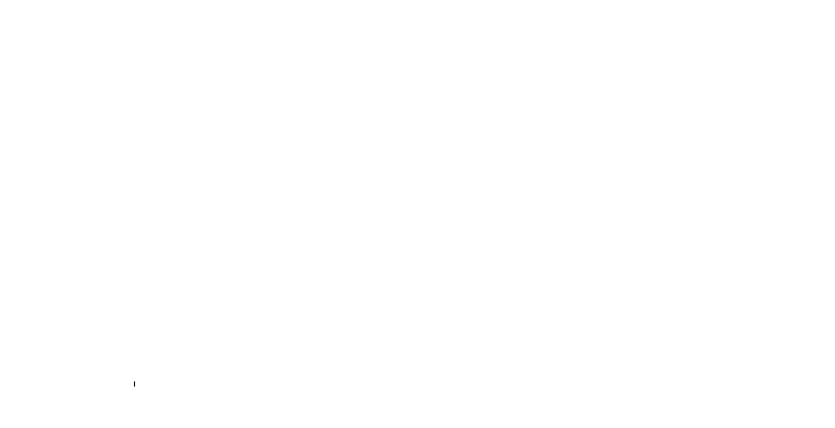

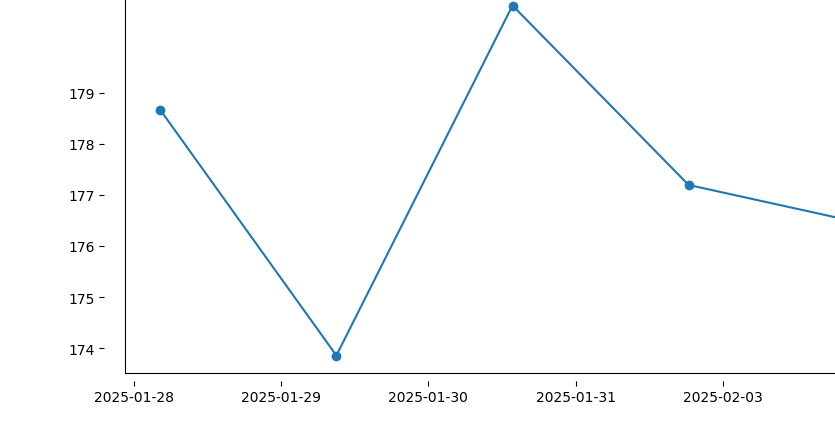

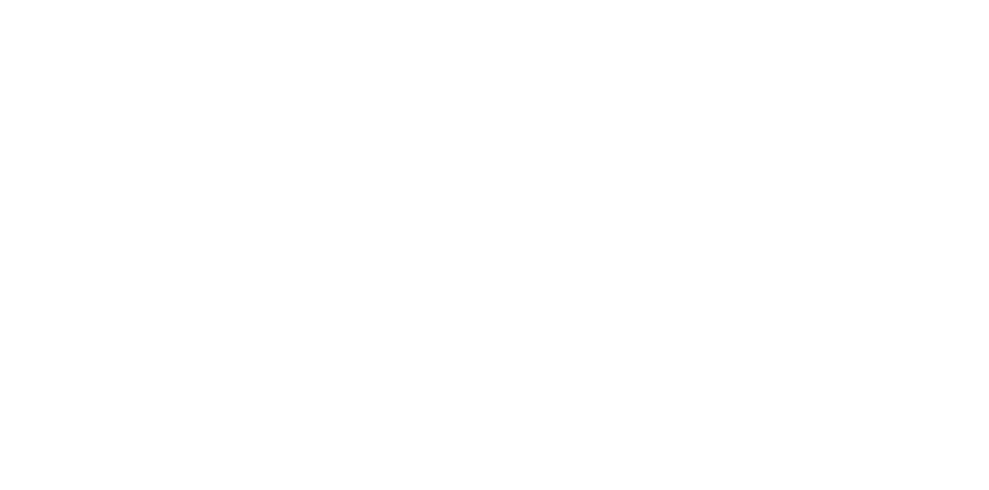

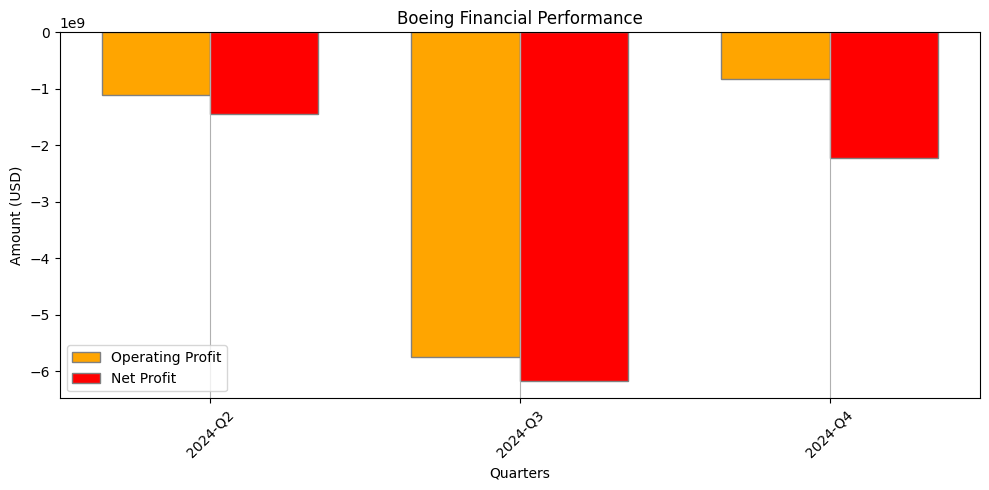

{'Chart_Generator': {'messages': [HumanMessage(content="Here are the charts representing Boeing (BA) stock prices and financial performance:\n\n1. **Boeing (BA) Stock Prices Over the Last 5 Days**:\n   - This chart shows the variation in stock price of Boeing over the last five days of trading.\n\n2. **Boeing Financial Performance**:\n   - This bar chart illustrates Boeing's operating and net profits for the recent quarters, highlighting the financial challenges the company is facing.\n\nYou can analyze these charts to assist in your decision-making regarding purchasing Boeing stock.", additional_kwargs={}, response_metadata={}, name='Chart_Gernerator')]}}
----
supervisor called
{'supervisor': {'next': 'FINISH'}}
----


In [55]:
for s in graph.stream({"messages": [HumanMessage(content="보잉 주식 구매 의사 결정 도와줘")]}):
    if "__end__" not in s:
        print(s)
        print("----")